# Analysis - Language time 

In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from utils.cuda_cluster import *
from utils.dataset import read_data, factorize_small_cardinality
from utils.util import get_day_phase, get_hours_from_midnight_of_current_day

import core.config as conf

/home/hyez/anaconda3/envs/dask-cudf/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37855 instead
  http_address["port"], self.http_server.port


In [4]:
client

Client Scheduler: tcp://127.0.0.1:35307 Dashboard: http://127.0.0.1:37855/status,Cluster Workers: 1 Cores: 1 Memory: 33.47 GB


## 1. Load data

In [3]:
# data_path = conf.raw_data_path + '*' # for all dataset
data_path = conf.raw_data_path + 'part-00175'
ori_df = read_data(data_path)

number of rows: 3033347


In [8]:
%%time

ori_df, _ = factorize_small_cardinality(ori_df, 'language')

CPU times: user 230 ms, sys: 18.2 ms, total: 248 ms
Wall time: 3.19 s


In [11]:
languages = ori_df[['language_encode']]
timestamps = ori_df[['tweet_timestamp']]

In [12]:
languages.head()

,language_encode
id,
1,48
2,43
3,46
4,5
5,61


In [13]:
timestamps.head()

,tweet_timestamp
id,
1,1612993854
2,1612886900
3,1614019237
4,1612779567
5,1613822114


In [23]:
languages['language_encode'].value_counts().compute().sort_index()

0       8238
1         39
2       1018
3       1287
4       3349
       ...  
61    521201
62      2709
63       183
64      1360
65       268
Name: language_encode, Length: 66, dtype: int64

In [28]:
indices = languages[languages['language_encode'] == 3].index.compute()
indices

Int32Index([   2322,    2828,    4294,    7493,    9587,   12145,   13492,
              14186,   15816,   16965,
            ...
            3023769, 3024074, 3024365, 3024898, 3026247, 3029445, 3031093,
            3032296, 3032350, 3032663],
           dtype='int32', name='id', length=1287)

In [114]:
mas = 65+1

times = [0 for i in range(0,mas)]

for i in range(0,mas):
    times[i] = timestamps[languages['language_encode'] == i].compute()
    
times[0].head()

,tweet_timestamp
id,
46,1613123039
266,1612610511
271,1612901010
472,1613065846
529,1612981181


In [115]:
%%time
hours = [dask_cudf.Series for i in range(0,mas)]

for i in range(0, mas):
    hours[i] = times[i].astype('datetime64[s]')
    hours[i]['hour'] = hours[i]['tweet_timestamp'].dt.hour
    hours[i] = hours[i].drop('tweet_timestamp', axis=1)
    
hours[0].head()

CPU times: user 66.1 ms, sys: 4.04 ms, total: 70.1 ms
Wall time: 68.6 ms


,hour
id,
46,9
266,11
271,20
472,17
529,18


In [122]:
count = hours[0]['hour'].value_counts().sort_index()
count

0      41
1     111
2     181
3     250
4     276
5     353
6     336
7     412
8     432
9     426
10    484
11    436
12    447
13    536
14    538
15    561
16    615
17    573
18    483
19    309
20    197
21    117
22     73
23     51
Name: hour, dtype: int32

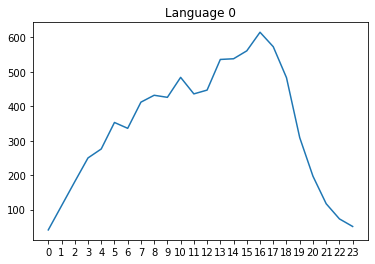

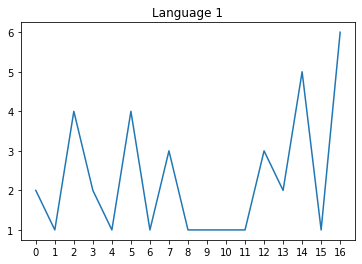

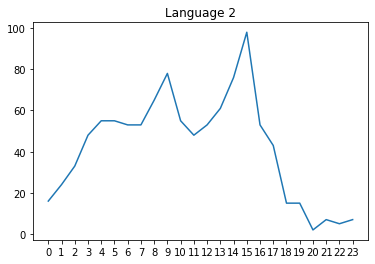

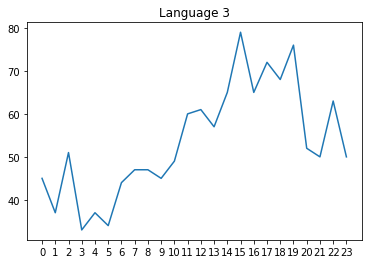

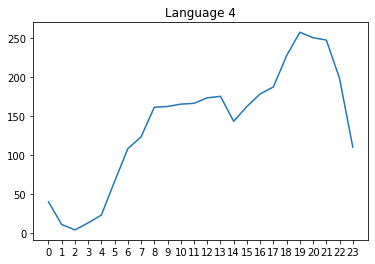

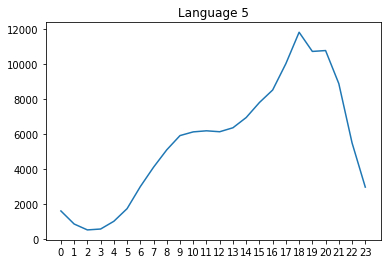

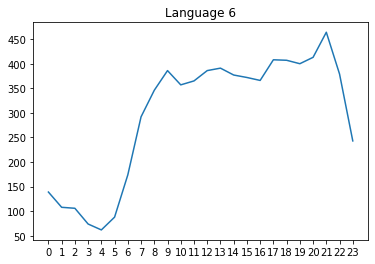

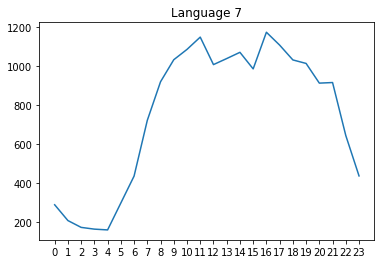

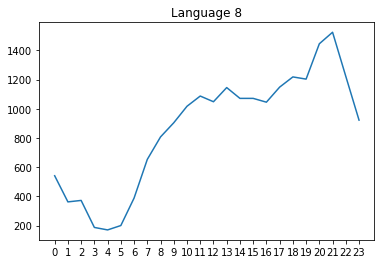

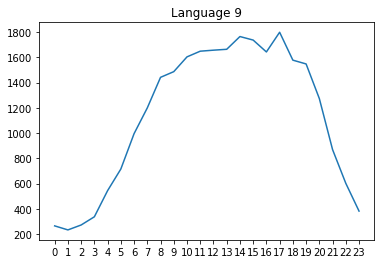

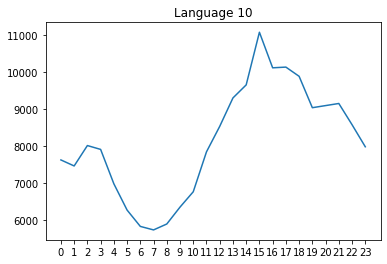

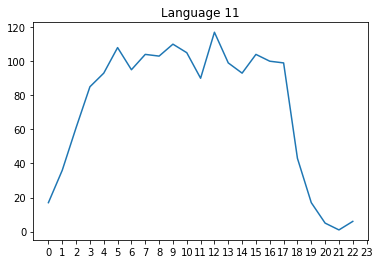

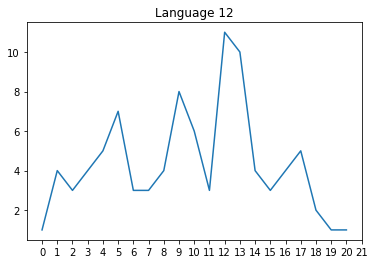

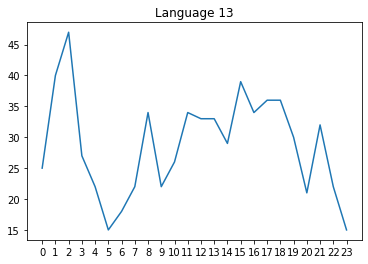

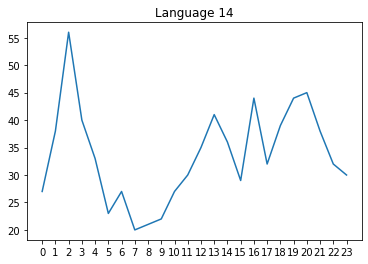

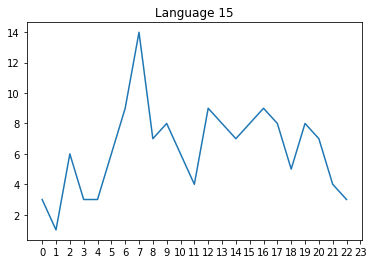

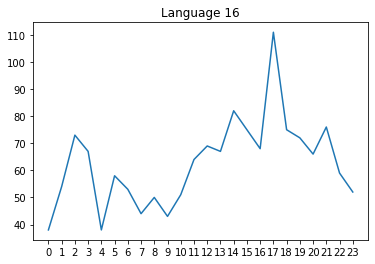

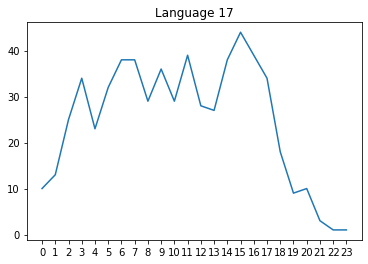

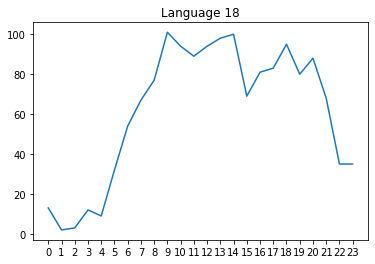

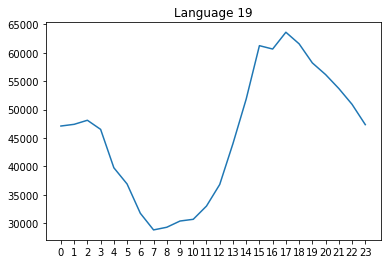

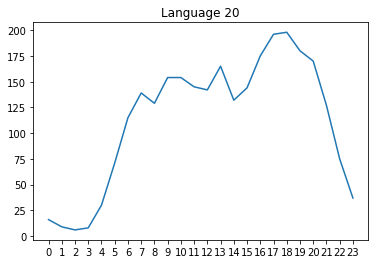

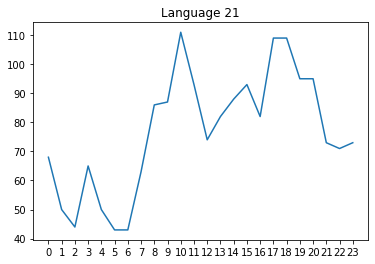

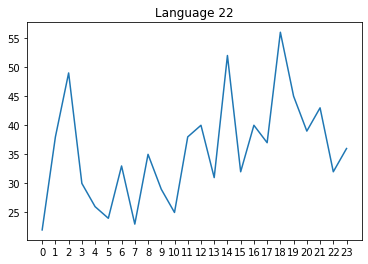

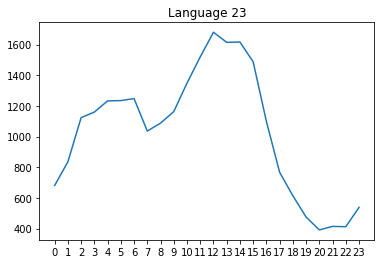

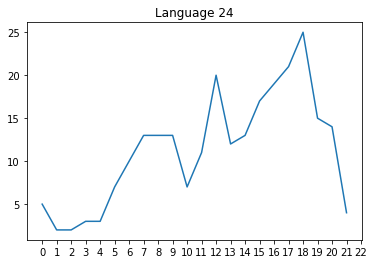

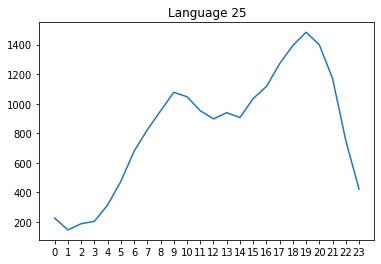

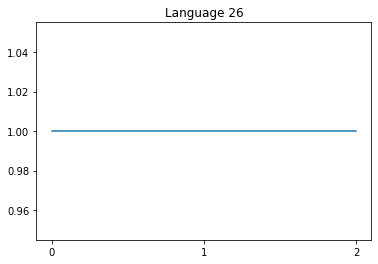

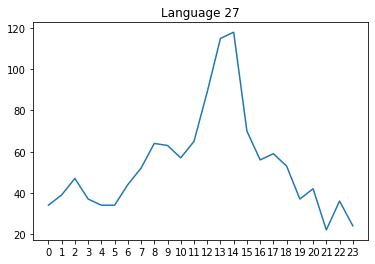

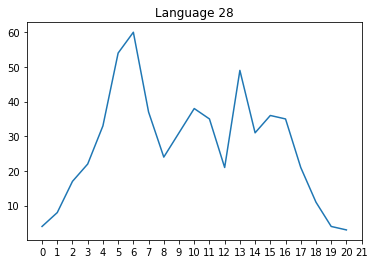

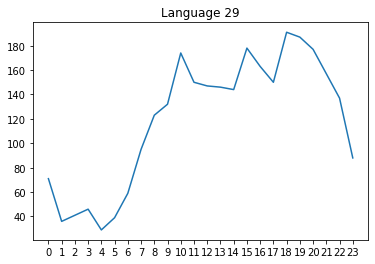

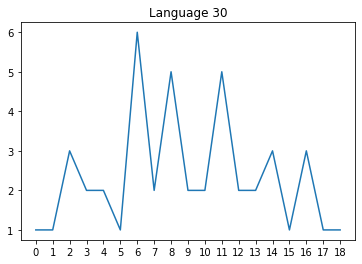

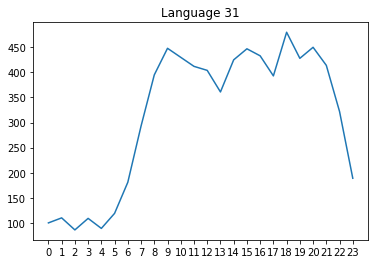

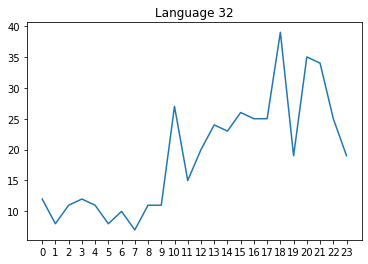

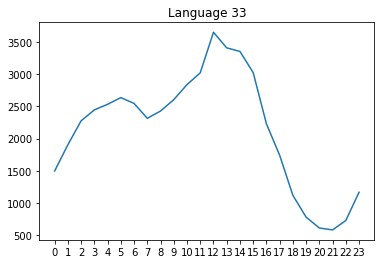

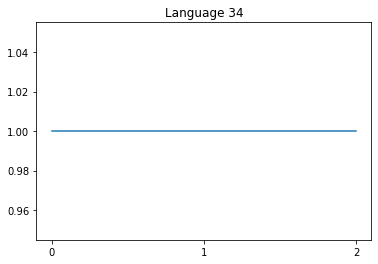

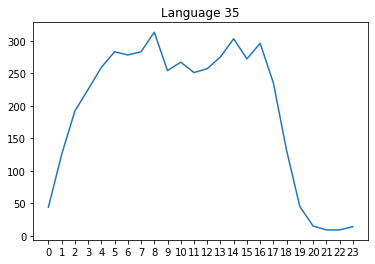

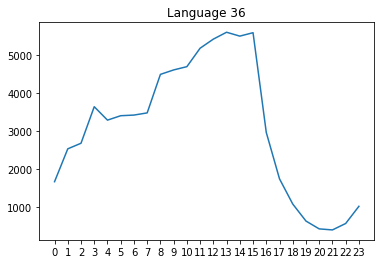

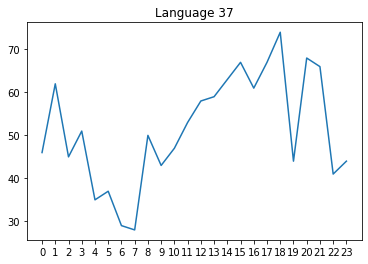

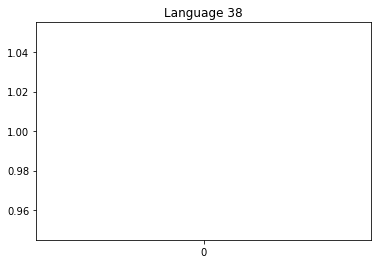

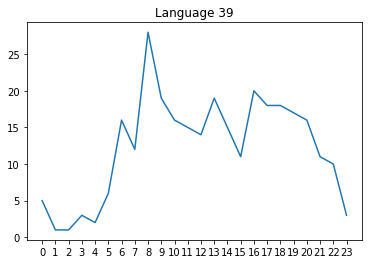

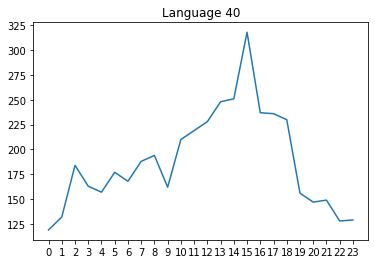

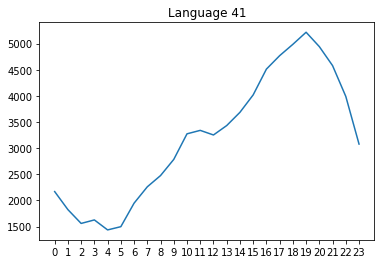

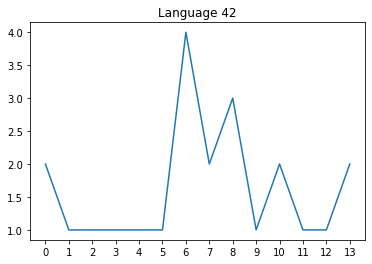

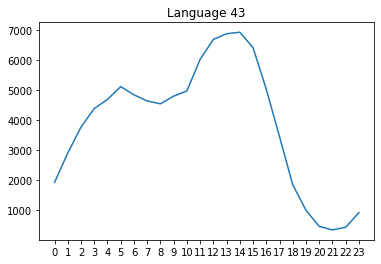

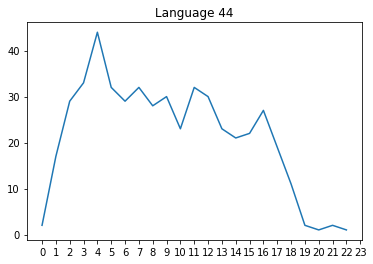

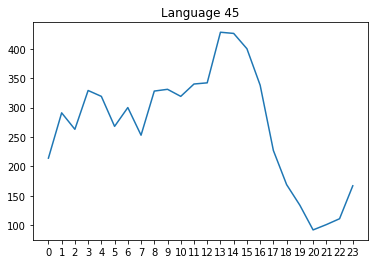

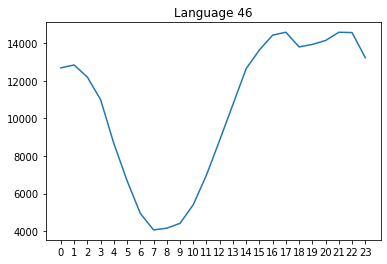

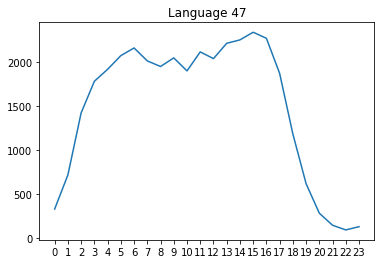

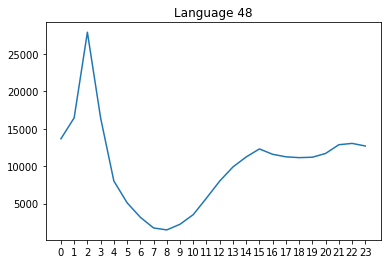

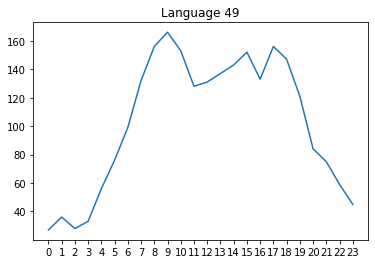

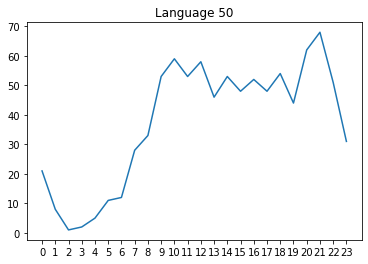

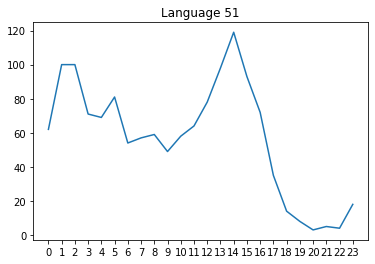

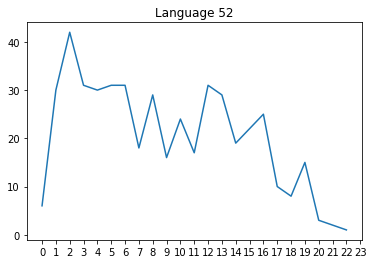

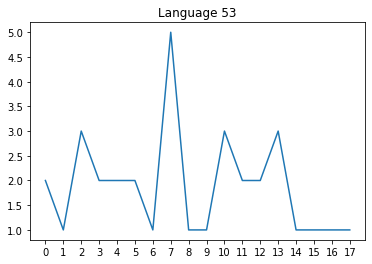

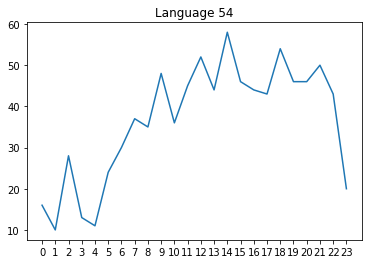

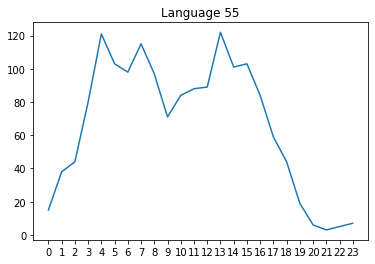

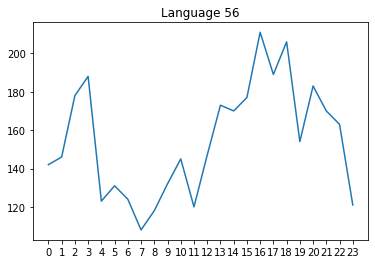

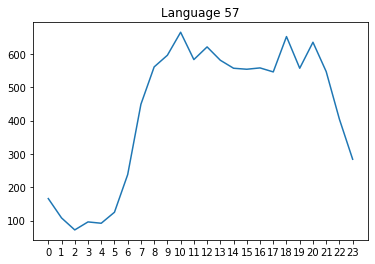

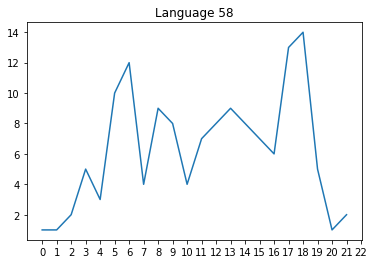

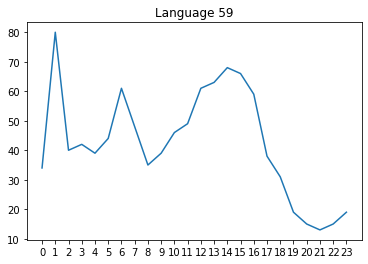

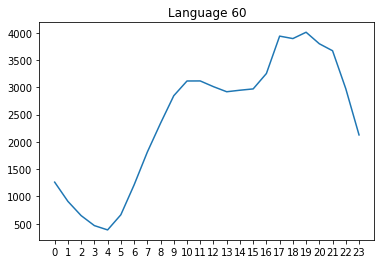

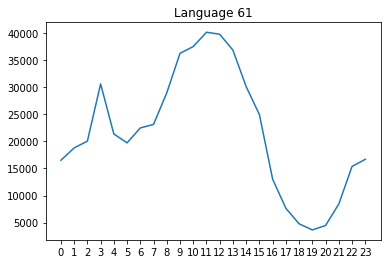

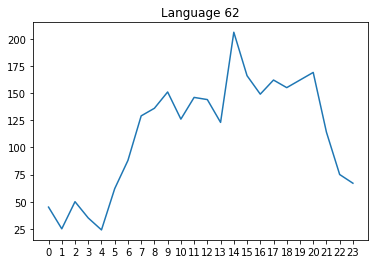

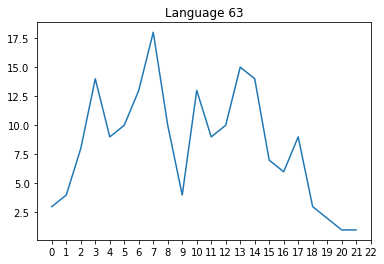

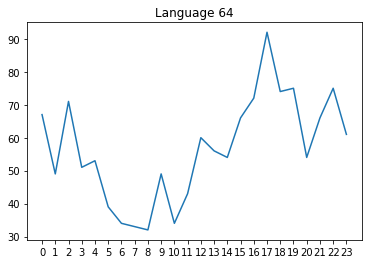

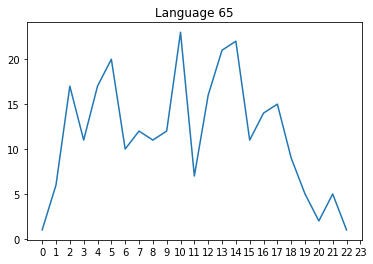

In [186]:

for i in range(0,mas):    
    plt.title(f"Language {i}")
    plt.xticks(range(0,24))
    plt.plot(hours[i]['hour'].value_counts().sort_index().to_array())
    plt.show()